In [1]:
import sys
import math
import numpy as np
import pickle
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from collections import defaultdict
from scipy.interpolate import griddata

In [2]:
CIs = {'90': 1.645, '95': 1.96, '99': 2.576}

In [3]:
Data_Root = '/l/nx/data/haopeng/Diffusion/SBM/'

In [4]:
num_nodes = 100000
avg_degree = 10
num_edges = num_nodes*avg_degree/2
num_community = 2
thsh = 0.35
rho = 0.10
num_seeds = int(rho*num_nodes)
f = 0.01 #0.001, 1.0

In [5]:
# see `sbm_analytical.ipynb`

with open(Data_Root+'analy_nodes_%sk_z_%s_thsh_%s_rho0_%s_f_%s.pickle'%(num_nodes//1000, avg_degree, thsh, rho, f), 'rb') as file:
    results_analy = pickle.load(file)

In [6]:
# see `sbm_simulation.ipynb`

with open(Data_Root+'simu_nodes_%sk_z_%s_thsh_%s_rho0_%s_f_%s.pickle'%(num_nodes//1000, avg_degree, thsh, rho, f), 'rb') as file:
    results = pickle.load(file)

In [7]:
num_runs = len(results[0])

In [8]:
num_runs

100

In [9]:
us = np.arange(0, 0.51, 0.01)

## Fig. 1

In [10]:
avg_rates, std_rates = [], []
avg_sizes, std_sizes = [], []

for u in us:
    speeds = [(size-num_seeds)/(num_nodes*step) for (size, step, activation_per_step) in results[u]]
    avg_rates.append(np.mean(speeds))
    median = np.median(speeds)
    q75, q25 = np.percentile(speeds, [75 ,25])
    # iqr = q75 - q25
    std_rates.append([median-q25, q75-median])
    sizes_ = [size/num_nodes for (size, step, activation_per_step) in results[u]]
    avg_sizes.append(np.mean(sizes_))
    median = np.median(sizes_)
    q75, q25 = np.percentile(sizes_, [75 ,25])
    std_sizes.append([median-q25, q75-median])

In [11]:
# determine green region based on analytical results

rates = []
sizes = []

for u in us:
    step_size = results_analy[u][0]
    total_step = len(step_size)-1
    final_size = step_size[total_step][0]
    sizes.append(final_size)
    avg_rate = (final_size - step_size[0][0]) / total_step
    rates.append(avg_rate)

In [12]:
lower_u, upper_u = 'none', 'none'

for u, size in zip(us, sizes):
    if size >= 0.99:
        if lower_u == 'none':
            lower_u = u
        upper_u = u

optimal_u = 0
min_rate = min(rates)
for u, rate in zip(us, rates):
    if u >= lower_u and u <= upper_u:
        if rate > min_rate:
            optimal_u = u
            min_rate = rate

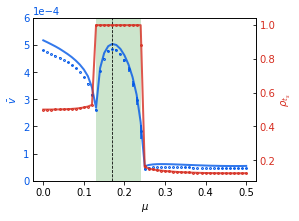

In [13]:
fig, ax = plt.subplots(figsize = (4, 3))

col1 = '#0057e7'
ax.errorbar(us, avg_rates, yerr=np.array(std_rates).T, color=col1, fmt='H', fillstyle='none', markersize=2)
ax.plot(us, rates, color=col1, marker='None', linestyle='-', linewidth = 2, alpha=0.8)
ax.set_xlabel(r'$\mu$')
ax.set_ylabel(r'$\bar{v}$', color=col1)
ax.tick_params(axis='y', labelcolor = col1, direction='in')
ax.axvspan(lower_u, upper_u, color='green', alpha=0.2, linewidth=0)
ax.axvline(optimal_u, color='k', linestyle='--', linewidth = 0.8)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.set_ylim([0, 6e-4])

col2 = '#d62d20'
ax2 = ax.twinx()
ax2.errorbar(us, avg_sizes, yerr=np.array(std_sizes).T, color=col2, fmt='H', fillstyle='none', markersize=2)
ax2.plot(us, sizes, color=col2, marker='None', linestyle='-', linewidth = 2, alpha=0.8)
ax2.set_ylabel(r'$\rho_{t_s}$', color=col2)
ax2.tick_params(axis='y', labelcolor = col2, direction='in')

plt.show()
fig.savefig('figure_1.pdf', bbox_inches='tight', pad_inches=0.01)

## Fig. 2

In [14]:
cand_us = [lower_u, optimal_u, 0.21]

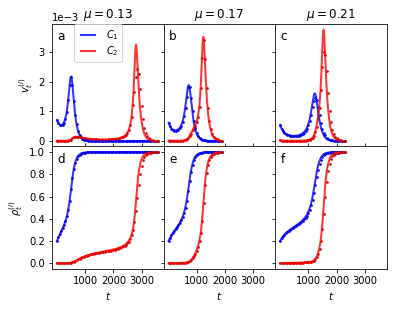

In [15]:
fig, axes = plt.subplots(2, len(cand_us), sharey='row', sharex=True, figsize = (6, 4.5))

colors = ['b', 'r']
labels = [r'$C_1$', r'$C_2$']
one_subs = ['a', 'b', 'c']
two_subs = ['d', 'e', 'f']
gap = 50

# speed
for i, u, sub in zip(range(len(cand_us)), cand_us, one_subs):
    ax = axes[0, i]
    max_step = 0
    for size, step, _ in results[u]:
        if step > max_step:
            max_step = step
    xs = np.arange(max_step)
#     if len(xs) > 3000:
#         gap = 120
#     else:
#         gap = 100
    for j, col, label in zip(range(num_community), colors, labels):
        mat = np.zeros((num_runs, max_step))
        for m in range(num_runs):
            activation_per_step = results[u][m][2][j]
            for n in range(len(activation_per_step)):
                mat[m, n] = activation_per_step[n]/(num_nodes*0.5)
        avg_speed_step = np.mean(mat, axis=0)
        ax.plot(xs[:-1:gap], avg_speed_step[1::gap], color=col, alpha=0.8, marker='H', fillstyle='none', markersize=2, linewidth=0)
    ax.set_title(r'$\mu={:3.2f}$'.format(u))
    # ax.set_xticklabels([])
    ax.tick_params(axis='x', direction='in')
    ax.text(0.05, 0.95, sub, fontsize=12, ha='left', va='top', transform=ax.transAxes)

for i, u in zip(range(len(cand_us)), cand_us):
    ax = axes[0, i]
    step_speed = results_analy[u][1]
    xs = range(len(step_speed))
    for j, col, label in zip(range(num_community), colors, labels):
        speed_step = [step_speed[step][j+1] for step in xs]
        ax.plot(xs[::1], speed_step[::1], label=label, color=col, alpha=0.8, marker='None', linestyle='-', linewidth = 2)
        

# size 
for i, u, sub in zip(range(len(cand_us)), cand_us, two_subs):
    ax = axes[1, i]
    max_step = 0
    for size, step, _ in results[u]:
        if step > max_step:
            max_step = step
    xs = np.arange(max_step)
    for j, col, label in zip(range(num_community), colors, labels):
        mat = np.ones((num_runs, max_step))
        for m in range(num_runs):
            activation_per_step = results[u][m][2][j]
            cum_seq = np.cumsum(activation_per_step)/(num_nodes*0.5)
            for n in range(len(cum_seq)):
                mat[m, n] = cum_seq[n]
        avg_cum_seq = np.mean(mat, axis=0)
        ax.plot(xs[::gap], avg_cum_seq[::gap], label=label, color=col, alpha=0.8, marker='H', fillstyle='none', markersize=2, linewidth=0)
    ax.set_xlabel(r'$t$')
    ax.set_xticks([1000, 2000, 3000, 4000, 5000])
    ax.text(0.05, 0.95, sub, fontsize=12, ha='left', va='top', transform=ax.transAxes)
    
for i, u in zip(range(len(cand_us)), cand_us):
    ax = axes[1, i]
    step_size = results_analy[u][0]
    xs = range(len(step_size))
    for j, col, label in zip(range(num_community), colors, labels):
        size_step = [step_size[step][j+1] for step in xs]
        ax.plot(xs[::1], size_step[::1], label=label, color=col, alpha=0.8, marker='None', linestyle='-', linewidth = 2)
        
legend = axes[0, 0].legend(loc='lower left', bbox_to_anchor=(0.15, 0.65), labelspacing=0.2, frameon=True, numpoints=2, markerscale=1)
axes[0, 0].set_ylabel(r'$v^{(i)}_t$')
axes[0, 0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
axes[1, 0].set_ylabel(r'$\rho^{(i)}_t$')
# axes[0].set_ylim([0, 5e-3])
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()
fig.savefig('figure_2.pdf', bbox_inches='tight', pad_inches=0)

## Fig. 3

First run the following scripts on hpc:
1. `sbm_fix_thsh_hpc.py` (records the per time step data for each run, which will be used in plotting optimal mu for different cascade sizes later).
2. `sbm_fix_rho0_hpc.py` (only records the average speed and the final size for each run).

In [20]:
class OOMFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.0f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_orderOfMagnitude(self, nothing):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin, vmax):
        self.format = self.fformat
        if self._useMathText:
            self.format = '$%s$' % matplotlib.ticker._mathdefault(self.format)

In [21]:
rhos = np.arange(0, 0.51, 0.01)
thshs = np.arange(0, 0.51, 0.01)
us = np.arange(0, 0.51, 0.01)

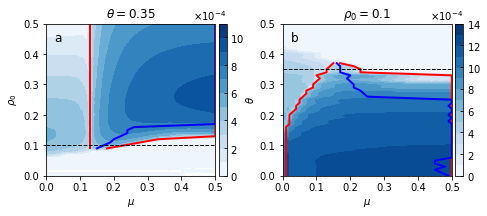

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, figsize = (7.5, 2.8))

num_nodes = 100000
avg_degree = 10
num_edges = num_nodes*avg_degree/2
num_community = 2
thsh = 0.35
num_runs = 100
f = 0.01

# load data
with open(Data_Root+'per_step_data/phase_simu_nodes_%sk_z_%s_thsh_%s_f_%s.pickle'%(num_nodes//1000, avg_degree, thsh, f), 'rb') as file:
    results = pickle.load(file)
    
sweeping_results = defaultdict(dict)

for rho in rhos:
    num_seeds = int(rho*num_nodes)
    for u in us:
        tem_results = []
        for size, step, activation_per_step in results[rho][u]:
            tem_results.append((size, step))
        sizes = [size/num_nodes for (size, step) in tem_results]
        rates = [(size-num_seeds)/(step*num_nodes) if step > 0 else 0 for (size, step) in tem_results]
        sweeping_results[rho][u] = (sizes, rates)
        

x_range = np.arange(0, 0.51, 0.001)
y_range = np.arange(0, 0.51, 0.001)
X, Y = np.meshgrid(x_range, y_range)

points = []
values_size = []
values_rate = []
lower_boundary = []
upper_boundary = []
max_rate = []
            
for rho in rhos:
    lower_u, upper_u = 'none', 'none'
    for u in us:
        points.append([u, rho])
        avg_size = np.mean(sweeping_results[rho][u][0])
        values_size.append(avg_size)
        avg_rate = np.mean(sweeping_results[rho][u][1])
        values_rate.append(avg_rate)
        
        if avg_size >= 0.99:
            if lower_u == 'none':
                lower_u = u
            upper_u = u
    if lower_u < upper_u:
        lower_boundary.append([lower_u, rho])
        upper_boundary.append([upper_u, rho])
        optimal_u = 0
        min_rate = np.mean(sweeping_results[rho][lower_u][1])
        for u in us:
            if u >= lower_u and u <= upper_u:
                avg_rate = np.mean(sweeping_results[rho][u][1])
                if avg_rate >= min_rate:
                    optimal_u = u
                    min_rate = avg_rate
        max_rate.append([optimal_u, rho])

lower_boundary = np.array(lower_boundary)
upper_boundary = np.array(upper_boundary)
max_rate = np.array(max_rate)

Z_size = griddata(points, values_size, (X, Y), method = 'cubic')
Z_rate = griddata(points, values_rate, (X, Y), method = 'cubic')

ax = axes[0]
levels = np.linspace(0.0, 11e-4, 12)
ct = ax.contourf(X, Y, Z_rate, cmap = 'Blues', levels=levels)#, extend='min'
cb = fig.colorbar(ct, ax=ax, fraction=0.05, pad=0.02, format=OOMFormatter(-4, mathText=True))
cb.ax.tick_params(axis='y', direction='in')

ax.plot(lower_boundary[:, 0], lower_boundary[:, 1], linewidth = 2, color='r')
ax.plot(upper_boundary[:, 0], upper_boundary[:, 1], linewidth = 2, color='r')
ax.plot(max_rate[:, 0], max_rate[:, 1], linewidth = 2, color='b')
ax.axhline(y=0.10, linewidth=1, linestyle='--', color='k')
ax.text(0.05, 0.95, 'a', fontsize=12, ha='left', va='top', transform=ax.transAxes)
ax.set_xlabel(r'$\mu$')
ax.set_ylabel(r'$\rho_0$')
ax.set_title(r'$\theta=0.35$')
ax.set_xlim(0, 0.5)
ax.set_ylim(0, 0.5)

# b

num_nodes = 100000
avg_degree = 10
num_edges = num_nodes*avg_degree/2
num_community = 2
rho = 0.10
num_seeds = int(rho*num_nodes)
num_runs = 100
f = 0.01

# load data
with open(Data_Root+'phase_simu_nodes_%sk_z_%s_rho0_%s_f_%s.pickle'%(num_nodes//1000, avg_degree, rho, f), 'rb') as file:
    sweeping_results = pickle.load(file)
        
x_range = np.arange(0, 0.51, 0.001)
y_range = np.arange(0, 0.51, 0.001)
X, Y = np.meshgrid(x_range, y_range)

points = []
values_size = []
values_rate = []
lower_boundary = []
upper_boundary = []
max_rate = []
            
for thsh in thshs:
    lower_u, upper_u = 'none', 'none'
    for u in us:
        points.append([u, thsh])
        avg_size = np.mean(sweeping_results[thsh][u][0])
        values_size.append(avg_size)
        avg_rate = np.mean(sweeping_results[thsh][u][1])
        values_rate.append(avg_rate)
        
        if avg_size >= 0.99:
            if lower_u == 'none':
                lower_u = u
            upper_u = u
    if lower_u < upper_u:
        lower_boundary.append([lower_u, thsh])
        upper_boundary.append([upper_u, thsh])
        optimal_u = 0
        min_rate = np.mean(sweeping_results[thsh][lower_u][1])
        for u in us:
            if u >= lower_u and u <= upper_u:
                avg_rate = np.mean(sweeping_results[thsh][u][1])
                if avg_rate >= min_rate:
                    optimal_u = u
                    min_rate = avg_rate
        max_rate.append([optimal_u, thsh])

lower_boundary = np.array(lower_boundary)
upper_boundary = np.array(upper_boundary)
max_rate = np.array(max_rate)

Z_size = griddata(points, values_size, (X, Y), method = 'cubic')
Z_rate = griddata(points, values_rate, (X, Y), method = 'cubic')

ax = axes[1]
levels = np.linspace(0.0, 14e-4, 15)
ct = ax.contourf(X, Y, Z_rate, cmap = 'Blues', levels=levels)#, extend='min'
cb = fig.colorbar(ct, ax=ax, fraction=0.05, pad=0.02, format=OOMFormatter(-4, mathText=True))
cb.ax.tick_params(axis='y', direction='in')
ax.plot(lower_boundary[:, 0], lower_boundary[:, 1], linewidth = 2, color='r')
ax.plot(upper_boundary[:, 0], upper_boundary[:, 1], linewidth = 2, color='r')
ax.plot(max_rate[:, 0], max_rate[:, 1], linewidth = 2, color='b')
ax.axhline(y=0.35, linewidth=1, linestyle='--', color='k')
ax.text(0.05, 0.95, 'b', fontsize=12, ha='left', va='top', transform=ax.transAxes)
ax.set_xlabel(r'$\mu$')
ax.set_ylabel(r'$\theta$')
ax.set_title(r'$\rho_0=0.1$')
ax.set_xlim(0, 0.5)
ax.set_ylim(0, 0.5)
fig.subplots_adjust(wspace=0.3)
plt.show()
fig.savefig('figure_3.pdf', bbox_inches='tight', pad_inches=0.02)